# Nano indenter
v2: Add a file path to the output folder, so modified data ends up in the process folder

In [37]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time as t
import pyFAI as pyFAI
from pyFAI.gui import jupyter
import fabio as fabio
import os as os



from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#import matplotlib.pylab as pylab
#params = {'legend.fontsize': 'large',
#          'figure.figsize': (15, 5),
#         'axes.labelsize': 'large',
#         'axes.titlesize':'large',
#         'xtick.labelsize':'large',
#         'ytick.labelsize':'large'}
#pylab.rcParams.update(params)
##?xx-small?, ?x-small?, ?small?, ?medium?, ?large?, ?x-large?, ?xx-large?. 

from time import time

# Bokeh might to try to load some javascript and that causes problems
#try out a new library
#from bokeh.io import output_file, show, output_notebook
#from bokeh.plotting import figure

In [31]:
# Class definition
class PilatusData:
    def __init__(self, data_input_file, output_path, poni_file=None, mask_file=None):
        """ Empty space are boring ... """
        # Store locals
        self.data_input_file = data_input_file
        # set output_path and remove trailing backslash
        self.output_path = os.path.normpath(output_path)
        self.mask = mask_file
        if self.mask:
            self.mask_data = fabio.open(self.mask).data
        self.poni = poni_file
        if self.poni:
            self.ai = pyFAI.load(self.poni)
        # Separate file path from file name
        self.filepath_input_file, self.filename = os.path.split(data_input_file)
        # Open the file and store number of data entries
        with h5py.File(self.data_input_file, 'r') as hf:
            self.data_keys = list(hf.keys())
            self.total_number_entries = len(self.data_keys)
        # Check that data file exist
        with h5py.File(self.data_input_file, 'r'):
            pass
        # self.file_reader = file_reader(self.data_input_file)

    def data_read(self, entry_number):
        """ Open file and read data"""
        with h5py.File(self.data_input_file, 'r') as file_reader:
            return self._data_read(file_reader, entry_number)

    def _data_read(self, file_reader, entry_number):
        """ Read data from an open file"""
        # returns one detector image
        h5data = file_reader.get(self.data_keys[entry_number] + '/measurement/Pilatus/data')
        return np.squeeze(np.array(h5data))

    def split_filename_extension(self, filename):
        """ Read data from an open file"""
        filename_no_ext, _ = os.path.splitext(filename)
        return filename_no_ext

    def data_sum_up_all(self, generate_calibration2d_file=False):
        """ Sum all data up into one numpy array"""

        # Allocate some space
        with h5py.File(self.data_input_file, 'r') as file_reader:
            pilatusdata_sum = self._data_read(file_reader, 0)
            for i in range(1, self.total_number_entries):
                pilatusdata_sum += self._data_read(file_reader, i)
            if generate_calibration2d_file:
                filename_no_ext = self.split_filename_extension(self.filename)
                # output_name = self.filepath_input_file + "/" + filename_no_ext + "_summed.npy"
                output_name = self.output_path + "/" + filename_no_ext + "_summed.npy"
                np.save(output_name, pilatusdata_sum)
        return pilatusdata_sum

    def data_integrate1d(self, pilatusdata, output_name=None, radial_range=None, azimuth_range=None, **kwargs):
        """ This function generates 1d integrated data.
            Input arguments:
            pilatusdata: A numpy array
            radial_range: select q-range
            azimuth_range: select azimuthal angle
            output_name: select a name for the output file #check for output path?

            Output:
            Returns: q/2th/r bins center positions and regrouped intensity (and error array if variance or variance model provided), uneless all==True.
            Return type: Integrate1dResult, dict
        """
        if not self.poni:
            raise ValueError("No poni file is defined, integration is impossible")
        if not self.mask:
            raise ValueError("No mask file is defined, integration is impossible")

        # Perform integrate1d
        return self.ai.integrate1d(
            data=pilatusdata,
            npt=1800,
            filename=output_name,
            unit="q_A^-1",  # unit="q_nm^-1",  #unit="2th_deg",
            radial_range=radial_range,
            azimuth_range=azimuth_range,
            mask=self.mask_data,
            correctSolidAngle=True,
            **kwargs)

    def data_integrate2d(self, pilatusdata, npt_rad, output_name=None, radial_range=None, azimuth_range=None, **kwargs):
        """ Calculate the azimuthal regrouped 2d image in q(nm^-1)/chi(deg) by default"""
        if not self.poni:
            raise ValueError("No poni file is defined, integration is impossible")
        if not self.mask:
            raise ValueError("No mask file is defined, integration is impossible")
        if not npt_rad:
            raise ValueError("Provide number of points in the radial direction")

        # Perform integrate2d
        return self.ai.integrate2d(
            data=pilatusdata,
            npt_rad=npt_rad,
            npt_azim=3600,
            filename=output_name,
            correctSolidAngle=True,
            radial_range=radial_range,
            azimuth_range=azimuth_range,
            mask=self.mask_data,
            unit="q_A^-1",
            **kwargs)

    def sum_all_and_integrate1d(self, generate_calibration2d_file=False):
        output_filename = self.filepath_input_file + "/" + self.split_filename_extension(self.filename)
        sum_all = self.data_sum_up_all(generate_calibration2d_file)
        res = self.data_integrate1d(sum_all, output_name=output_filename + "_sum_all.dat")

        fig, ax = plt.subplots()
        plt.semilogy(res[0], res[1] / self.total_number_entries)  # I divide by the number of entries
        plt.title(self.data_input_file)  # self.filename
        # plt.xlabel('q (nm$^{-1}$)')
        plt.xlabel('2 theta (degrees)')
        plt.ylabel('Intensity')
        plt.grid(axis='both')

        majorLocator = MultipleLocator(5)
        majorFormatter = FormatStrFormatter('%d')
        minorLocator = MultipleLocator(1)

        ax.xaxis.set_major_locator(majorLocator)
        ax.xaxis.set_major_formatter(majorFormatter)
        ax.xaxis.set_minor_locator(minorLocator)

        # jupyter.plot1d(res)
        plt.show()

    def integrate1d_all(self, radial_range=None, azimuth_range=None, output_name=None,**kwargs):
        with h5py.File(self.data_input_file, 'r') as file_reader:
            return self._integrate1d_all(file_reader)

    def _integrate1d_all(self, file_reader, radial_range=None, azimuth_range=None, output_name=None,**kwargs):

        # create output filename
        output_filename = self.split_filename_extension(self.filename)
    
        # read the data for the first entry
        pilatusdata = self._data_read(file_reader, 0)
        # integrate it
        res = self.data_integrate1d(pilatusdata, radial_range=None, azimuth_range=None, output_name=None,**kwargs)
        
        #print("1d data is not radial integratable")
        # FIXME Why use pilatusdata[0]? This is 1D data, not a detector image.
        #res = self.data_integrate1d(pilatusdata[0], radial_range=None, azimuth_range=None, output_name=None)

        # create HDF file to store integrated data
        hdf5filename = None
        hdf5dsetname = "/entry/integ/data"
        if pilatusdata.ndim == 3:
            # create output hdf5file (rewrite)
            # hdf5filename = self.filepath_input_file + "/" + "{}_integ.h5".format(output_filename)
            hdf5filename = self.output_path + "/" + "{}_integ.h5".format(output_filename)
            with h5py.File(hdf5filename, "w") as h5f:
                # save q
                h5f.create_dataset("/entry/integ/q", data=res[0])
                # create a dataset for integrated data
                h5f.create_dataset(hdf5dsetname, shape=(self.total_number_entries, pilatusdata.shape[0], res[1].size),
                                   dtype=res[0].dtype,
                                   chunks=(self.total_number_entries, pilatusdata.shape[0], 10),
                                   compression="gzip")
        for i in range(0, self.total_number_entries):

            # flyscan adaptation
            pilatusdata = self._data_read(file_reader, i)
            # check what dimension the data entry has

            # A stepscan has dimension 2
            if pilatusdata.ndim == 2:
                # create filename for output file
                # output_name = self.filepath_input_file + "/" +  "{}_{:03d}.dat".format(output_filename, i)
                output_name = self.output_path + "/" + "{}_{:03d}.dat".format(output_filename, i)
                # FIXME data_integrate1d has only one positional argument, not two, use name of optional arguments instead
                #res = self.data_integrate1d(pilatusdata, output_name)
                res = self.data_integrate1d(pilatusdata, output_name=output_name)
                if i == 0:
                    fig, ax = plt.subplots()
                    plt.semilogy(res[0], res[1])
                    plt.title(self.data_input_file + " frame {}".format(i))  # self.filename
                    plt.xlabel('q (nm$^{-1}$)')
                    # plt.xlabel('2 theta (degrees)')
                    plt.ylabel('Intensity, one frame')
                    plt.grid(axis='both')

                    majorLocator = MultipleLocator(5)
                    majorFormatter = FormatStrFormatter('%d')
                    minorLocator = MultipleLocator(1)

                    ax.xaxis.set_major_locator(majorLocator)
                    ax.xaxis.set_major_formatter(majorFormatter)
                    ax.xaxis.set_minor_locator(minorLocator)

                    # jupyter.plot1d(res)
                    plt.show()

            # A flyscan has dimension 3
            elif pilatusdata.ndim == 3:
                # how many images are in one entry
                number_images_in_entry = pilatusdata.shape[0]

                # loop through the single images in one entry
                for n in range(number_images_in_entry):
                    # create filename for output file
                    # output_name = self.filepath_input_file + "/" + "{}_{:03d}_{:03d}.dat".format(output_filename, i,n)
                    output_name = self.output_path + "/" + "{}_{:03d}_{:03d}.dat".format(output_filename, i, n)
                    # FIXME data_integrate1d has only one positional argument, not two, use name of optional arguments instead
                    res = self.data_integrate1d(pilatusdata[n], None)
                    # save data to hdf5 file
                    with h5py.File(hdf5filename, "a") as h5f:
                        h5f[hdf5dsetname][i, n, :] = res[1]
            else:
                raise ValueError("Data dimension is wrong.")



# Data ploting

In [3]:
# Data file 
dirname='/data/visitors/nanomax/20190570/2019041008/raw/Si_calibration_20190415/'
output_path='/data/visitors/nanomax/20190570/2019041008/process/Si_calibration_20190415/'
os.chdir(dirname)
os.getcwd()
os.listdir(dirname)
file='scan_0000_pil1m_0000.hdf5'
source=dirname+file
print(source)

/data/visitors/nanomax/20190570/2019041008/raw/Si_calibration_20190415/scan_0000_pil1m_0000.hdf5


In [4]:
%time
start_time = time()

# your code
sicalib = PilatusData(source,output_path)
sicalib.data_sum_up_all(True)
print('Hallo')


elapsed_time = time() - start_time
print(elapsed_time)



CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 19.1 µs
Hallo
5.602002382278442


Start pyFAI, do a mask and the poni file

In [5]:
# Provide path to process folder that equals the output path
path_process='/data/visitors/nanomax/20190570/2019041008/process/Si_calibration_20190415/'
# Load the PONI file and the mask file
poni='PONI_Si_calibration_20190415.poni'  
mask='Mask_Si_calibration_20190415.edf'
poni_file=path_process+poni
mask_file=path_process+mask

In [6]:
# Provide sample path and output path
sample_path='/data/visitors/nanomax/20190570/2019041008/raw/as_deposited_2nd_indent_no_load/'
sample_file='scan_0000_pil1m_0000.hdf5'
source=sample_path+sample_file
output_path='/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/'

In [96]:
#fabio.hdf5image.Hdf5Image??

In [99]:
type(asdep_noload.ai)

pyFAI.azimuthalIntegrator.AzimuthalIntegrator

In [94]:
#%time

# Open a sample and one of its entries
asdep_noload=PilatusData(source,output_path,poni_file=poni_file,mask_file=mask_file)

#Choose one image and read it in
twod_image=asdep_noload.data_read(0)
print(type(twod_image))
#export the file


#fabio.hdf5image.Hdf5Frame(source, 0)

#testfile=fabio.hdf5image.Hdf5Image()

img=fabio.fabioimage.FabioImage(twod_image)

##Create output filename in one variable
output_filename=output_path+'asdep_noload_frame0.edf'

#Should work!
res=img.convert("edf").save(output_path+'asdep_noload_frame0.edf')
#res=img.convert("edf").save(output_filename)
print(output_path)






# Check out stepscan
print('Numbers of entries in a stepscan: {}'.format(asdep_noload.total_number_entries))
print('Dimension of one image: {}'.format(twod_image.ndim))
print('Shape of one image: {}'.format(twod_image.shape))


#out=asdep_noload.integrate1d_all()

<class 'numpy.ndarray'>
/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/
Numbers of entries in a stepscan: 5041
Dimension of one image: 2
Shape of one image: (1043, 981)


3.0

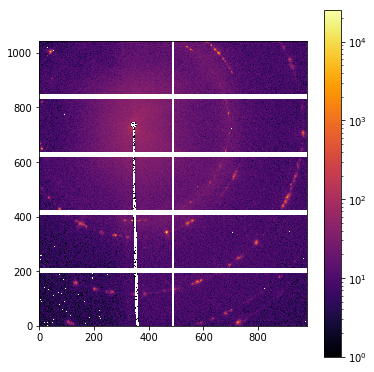

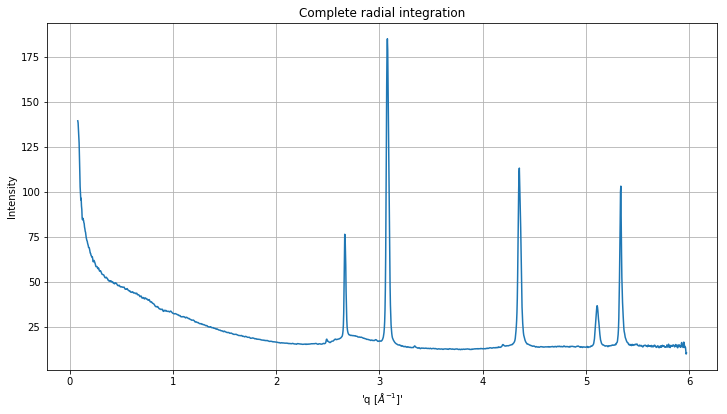

[  0  45  90 135 180 225 270 315]
0 -3 3
45 42 48
90 87 93
135 132 138
180 177 183
225 222 228
270 267 273
315 312 318


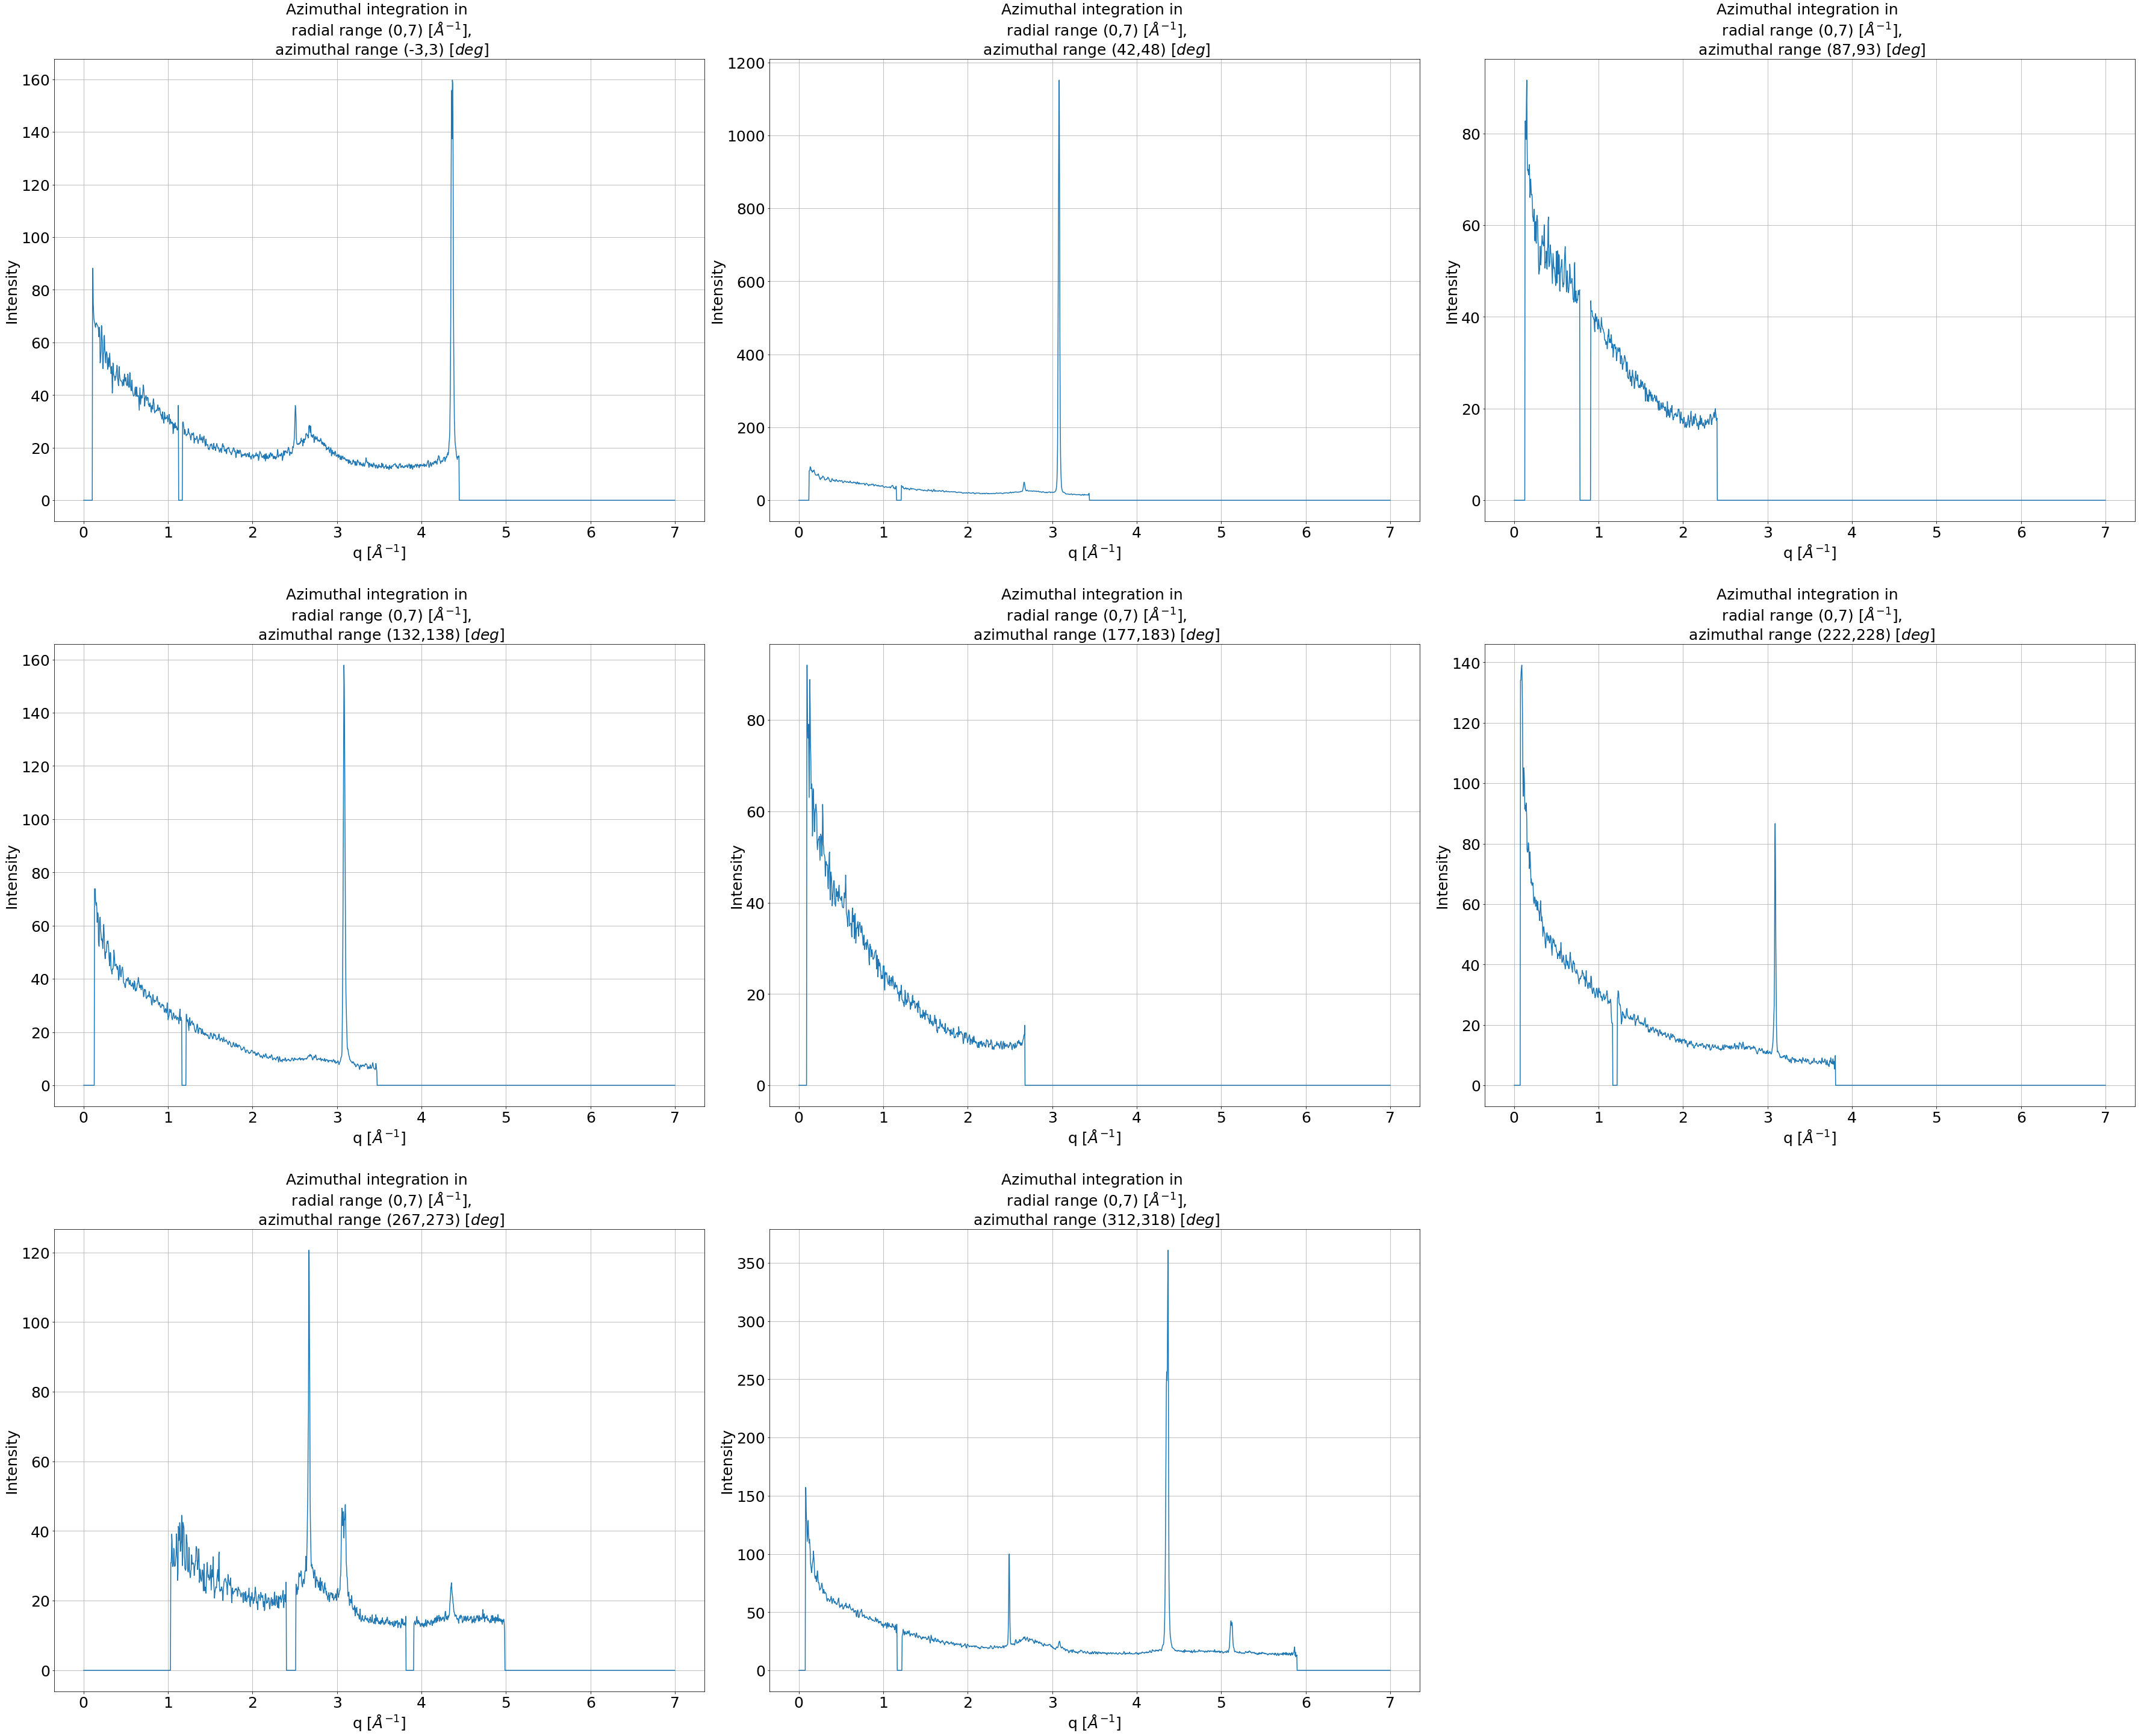

In [ ]:
#plot this entry with matplotlib
twod_image=asdep_noload.data_read(2500)
fig2d = plt.figure(figsize=(6,6*1.0632008154943935))
plt.imshow(twod_image, norm=LogNorm(),cmap = 'inferno',origin="lower")
plt.colorbar()
plt.show()


#################   Radial integration ###################################

#plot I(q) to get an idea what is going
oned_image=asdep_noload.data_integrate1d(twod_image)
fig, ax1 = plt.subplots(1, 1, figsize=(12,6*1.0632008154943935))
#plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
ax1.plot(oned_image[0],oned_image[1])
ax1.set(xlabel="'q $[\AA^{-1}]$'", ylabel="Intensity")
ax1.title.set_text('Complete radial integration')
ax1.grid(True)
plt.show()




#################   Test azimuth integration ###################################

#plot I(q) for a certain azimuthal range


# define q range, radial range
radial_range=(0,7) #q in Angström

dchi=1   #delta chi in degrees
#azimuth_values=np.array([0,90,180,275]) #four different quadrants


#define azimuth range
number_sectors=8
sector_size=360/number_sectors
#dchi=sector_size/2
dchi=3   #width of cake piece / sector

#azimuth_values=np.array([0,90,180,275]) #four different quadrants
#azimuth_values=np.array(range(-90, 181, 45))    
azimuth_values=np.array(range(0,360,int(sector_size)))
print(azimuth_values)

#prepare number of plots
number_azimuth_values=len(azimuth_values)

rows = 4
cols = number_azimuth_values // rows + 1


def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


figw,figh=50,50*1.0632008154943935
f, axs = plt.subplots(rows, cols,squeeze=True,figsize=(figw,figh))
#adjust subplots
plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh,wspace=figw/500, hspace=figh/200)
font1=25

axs = trim_axs(axs, len(azimuth_values))


      


#Plot the different sectors

for ax, i in zip(axs, azimuth_values):
#for n, i in enumerate(azimuth_values):
    asdep_noload.ai.reset()   
    ##set azimuth_range for each iteration, azimuth angle in degrees
    azimuth_range=(i-dchi,i+dchi) 
    print(i,i-dchi,i+dchi)

       
    
    #if 180.0>=azimuth_range[0] and 180.0<=azimuth_range[1]:
    #    # 180.0 discontinuity is in range then do it part by part
    #    q, i1 = asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=(azimuth_range[0],180.))
    #    q, i2 = asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=(180.,azimuth_range[1]))
    #    azimuth_image=(q,i1+i2)
    #else:    
    if azimuth_range[0]<180 and azimuth_range[1]>180:
        asdep_noload.ai.setChiDiscAtZero()
        azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    else:
        asdep_noload.ai.setChiDiscAtPi()
        azimuth_image=asdep_noload.data_integrate1d(twod_image,radial_range=radial_range,azimuth_range=azimuth_range)
    
    
    #plot=axs[n].plot(azimuth_image[0],azimuth_image[1])
    ax.plot(azimuth_image[0],azimuth_image[1])
        
    #axs[n].set(xlabel="'q $[\AA^{-1}]$'", ylabel="Intensity")
    #ax.set(xlabel="'q $[\AA^{-1}]$'", ylabel="Intensity")
   
    
    #axs[n].title.set_text("Azimuthal integration in \n radial range (%d,%d) $[\AA^{-1}]$,\n azimuthal range (%d,%d) $[deg]$"
    #               %(radial_range[0],radial_range[1], azimuth_range[0],azimuth_range[1]))
    #ax.title.set_text("Azimuthal integration in \n radial range (%d,%d) $[\AA^{-1}]$,\n azimuthal range (%d,%d) $[deg]$"
    #               %(radial_range[0],radial_range[1], azimuth_range[0],azimuth_range[1]))
    ax.set_title("Azimuthal integration in \n radial range (%d,%d) $[\AA^{-1}]$,\n azimuthal range (%d,%d) $[deg]$"
                   %(radial_range[0],radial_range[1], azimuth_range[0],azimuth_range[1]),fontdict={'fontsize': font1})
   
    ax.tick_params(labelsize=25)
    ax.set_xlabel('q $[\AA^{-1}]$',fontdict={'fontsize':font1})
    ax.set_ylabel('Intensity',fontdict={'fontsize':font1})

    #axs[n].grid(True)
    ax.grid(True)
  

    
plt.show()


#Play around with integrate2d
#res2d = ai.integrate2d(img, 300, 360, unit="2th_deg")
caked_image=asdep_noload.data_integrate2d(twod_image,npt_rad=3600)
#Example using pure matplotlib
I, tth, chi = caked_image
figcake=plt.figure(figsize=(6,6*1.0632008154943935))
plt.imshow(I, origin="lower", extent=[tth.min(), tth.max(), chi.min(), chi.max()], aspect="auto",norm=LogNorm(),cmap = 'inferno')
plt.xlabel("2 theta (deg)")
#plt.xlim([3,3.2])
plt.ylabel("Azimuthal angle chi (deg)")
plt.show()

In [119]:
number_sectors=4
sector_size=360/number_sectors
dchi=sector_size/2


print(isinstance(number_sectors, int))
print(type(numbers_sectors))

azimuth_values=np.array(range(0,360,int(sector_size)))
                        
for n,i in enumerate(azimuth_values):
    if (i-dchi)<0:
        lower_range=360+(i-dchi)
        upper_range=(i+dchi)
    else:
        lower_range=(i-dchi)
        upper_range=(i+dchi)
        
    print(n,i,lower_range,upper_range)
    


True


NameError: name 'numbers_sectors' is not defined

In [ ]:
#As deposited
#TiAlN in the coating (4-7um), bonding layer TiN (1um+- few hundred nanomers 1.5-1.3um),base: WCCo (mixuture)
#fcc TiAlN , potentiall hexagonal TiAlN (in small quantities)

#1000 C
#TiAlN in the coating (4-7um), bonding layer TiN (1um+- few hundred nanomers 1.5-1.3um),base: WCCo (mixuture)
#but also cubic TiN and hexagonal AlN (2 phases in the sample) (maybe there is cubic AlN)
#16% Ti, 84% Al, 1:1:2 Ti:Al:N

## 